## Выделение групп пользователей на основе поведения в мобильном приложении "Ненужные вещи"

### Шаг 1. Загрузка данных и изучение общей информации
- Загрузить данные и получить первичное представление об их структуре и наполнении. 

### Шаг 2. Предобработка данных
- Исследовать и обработать дубликаты;
- Исследовать и заменить пропущенные значения;
- В тех случаях, где необходимо, привести данные к соответствующим типам;
- Если необходимо, то изменить и привести названия столбцов к нижнему регистру;
- Объединить события show_contacts и contacts_show;
- Объединить события search_1 - search_7;
- Выделить из столбца с датой необходимые временные промежутки.

### Шаг 3. Исследовательский анализ данных
- Определить, сколько всего пользователей воспользовались приложением;
- Определить, сколько пользователей приносят нам наши источники;
- Построить график распределения событий по дням за исследуемый период;
- Посчитать конверсию пользователей в целевое событие - просмотр контактов;
- Определить время начала и конца события для каждого пользователя в приложении;
- Сконструировать таблицу с признаками, необходимыми для последующей кластеризации;
- Произвести рассчет следующих показателей: продолжительность каждого сеанса пользователя, количество совершения пользователем целевого действия, определить количество просмотров рекомендованных объявлений и добавлений объявления в избранное, посчитать общее время использования приложения для каждого пользователя;
- построить графики распределения для признаков и написать вывод;
- построить матрицу корреляция для признаков и написать вывод; 
- на основании получившихся признаков разобьем наших пользователей на группы при помощи ML;
- построить графики распредления признаков для кластеров и описать получившиеся кластеры.

### Шаг 4. Статистический анализ данных
- Проверить гипотезу: Конверсия в просмотр контактов между пользователя, установившими приложение по ссылке из yandex и пользователями, установившими приложение по ссылке из google, различается;
- Проверить гипотезу: Конверсия в добавление объявления в избранное между пользователями, установшими приложение по ссылке из yandex, различается от конверсии пользователей, установивших приложение по ссылке из google.

### Шаг 6. Общий вывод 
 - Написать общий вывод и составить небольшие рекомендации для маркетологов по повышению вовлеченности пользователей;
 - Подготовить презентацию с результатами исследований;
 - Подготовить дашборд в Tableau.

### Шаг 1. Загрузка данных и изучение общей информации

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import math as mth
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from matplotlib import pyplot
from matplotlib import rcParams

In [2]:
# отключим на будущее предупреждения об ошибках
import warnings
warnings.filterwarnings('ignore')

In [3]:
# прочитаем датасет data
data = pd.read_csv('/datasets/mobile_dataset.csv', sep = ',')

In [4]:
# прочитаем датасет sources
sources = pd.read_csv('datasets/mobile_soures.csv', sep = ',')

In [5]:
# первичное представление о данных 
for df in [data, sources]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
None


In [6]:
# проверка пропущенных значений
for df in [data, sources]:
    print(df.isna().sum())

event.time    0
event.name    0
user.id       0
dtype: int64
userId    0
source    0
dtype: int64


In [7]:
# проверка дубликатов 
for df in [data, sources]:
    print(df.duplicated().sum())

0
0


In [8]:
# первые пять строк датасетов
for df in [data, sources]:
    display(df.head())

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


### Вывод
- дубликатов и пропущенных значений не обнаружено;
- нужно изменить названия столбцов в обоих датасетах;
- привести столбец с датой к формату даты;
- необходимо изменить названия столбцов в обоих датасетах и привести их к нижнему регистру;
- привести столбец с датой к формату даты;
- объединить события show_contact и contact_show;
- объединить события search_1 - search_7 в одно.

### Шаг 2. Предобработка данных

In [9]:
# изменим названия столбцов data
data.columns = ['event_time', 'event_name', 'user_id']
data.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [10]:
# изменим названия столбцов sources
sources.columns = ['user_id', 'source']
sources.head()

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [11]:
# приведем столбцец event_time датасета data к формату даты, и округлим данные до 1 секунды
data['event_time'] = pd.to_datetime(data['event_time'], format='%Y.%m.%d %H:%M:%S').dt.round('1S')
data.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [12]:
# объединим события contacts_show и show_contacts
data = data.replace('contacts_show', 'show_contacts')

# объединим события search 
data = data.replace([['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7']], 'search')

# проверим
data['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
show_contacts     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

In [13]:
# объединим наши датасеты в один
data = data.merge(sources, on='user_id', how = 'right')
data.head()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other


In [14]:
# выделим из столбца с датой час, неделю, месяц, год и полную дату в отдельные столбцы
data['event_hour'] = data['event_time'].dt.hour # час
data['event_week'] = data['event_time'].astype('datetime64[W]') # неделя
data['event_month'] = data['event_time'].astype('datetime64[M]') # месяц
data['event_year'] = data['event_time'].astype('datetime64[Y]') # год
data['event_date'] = data['event_time'].astype('datetime64[D]') # полная дата

In [15]:
# посмотрим, что получилось
data.head()
data.to_csv('data.csv', index=False)

### Вывод
- по итогу шага выполнены все необходимые пробразования.

### Шаг 3. Исследовательский анализ данных

In [16]:
# посмотрим, сколько всего пользователей у нас есть
data['user_id'].nunique()

4293

##### Всего у нас в данных есть информация о 4293 пользователях.

In [17]:
# посмотрим, сколько пользователей приносят нам наши источники
data.groupby('source').agg({'user_id' : 'nunique'}).sort_values(by='user_id', ascending = False)

,user_id
source,
yandex,1934
other,1230
google,1129


- Больше всего трафика приносит yandex - 1934 пользователя;
- Меньше всего трафика приносит google - 1129 пользователей;
- Из других источников пришли 1230 пользователей. 

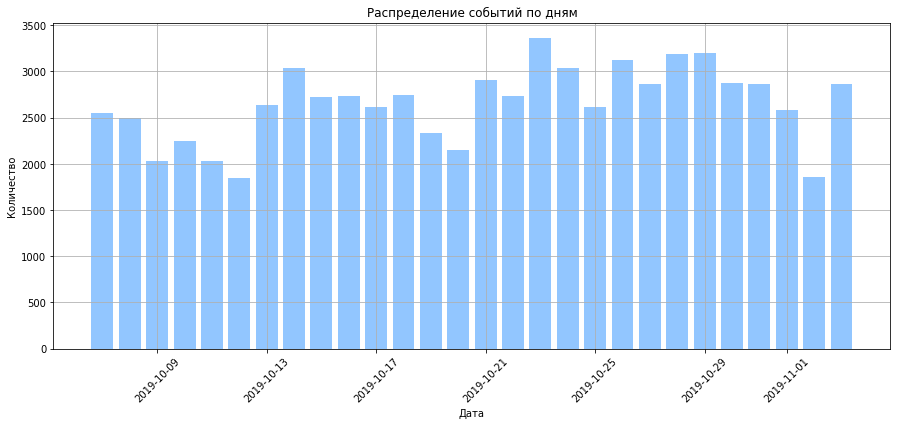

In [18]:
# распределение событий по дням
events_by_day = data.groupby('event_date', as_index=False).agg({'user_id':'count'})

plt.figure(figsize=(15,6))
with plt.style.context('seaborn-pastel'):
    plt.bar(events_by_day['event_date'], events_by_day['user_id'])
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.title('Распределение событий по дням')
plt.xticks(rotation=45)
plt.grid(True)
plt.show();

##### Выводы по графику:
- У нас есть данные с 7 октября 2019 года по 3 ноября 2019 года;
- Больше всего событий произошло 23 октября - почти 3500;
- Меньше всего событий произошло 12 октября и 2 ноября - 2000;
- Наименьшее количество событий, а также отрицательные спады зарегистрированы в выходные дни (12.10.2019 - суббота и 02.11.2019 - суббота). Однако в последние выходные дни октября наблюдается большая активность. Вполне вероятно, что это связано с получением заработной планы и желанием приобрести новые вещи, пока есть деньги. 
- Наибольший пик активности приходится на будние дни;
- Данные можно разделить на несколько промежутков. 1 неделя - с 07.10.2019 по 12.10.2019; 2 неделя - с 13.10.2019 по 20.10.2019; 3 неделя - с 21.10.2019 по 27.10.2019; 4 неделя с 28.10.2019 по 3.11.2019;
- В целом, события распределены нормально. Никаких аномалий не выявлено.

In [19]:
# посчитаем конверсию пользователей в целевое событие
(data.query('event_name=="show_contacts"')['user_id'].nunique() / data['user_id'].nunique()) * 100

22.851153039832283

##### Конверсия пользователей в целевое событие - просмотр контактов - составляет 23%.

In [20]:
# определим начало и конец каждого события пользователя в приложении

# начало сеанса
user_time_min = data.groupby(['user_id', 'event_date', 'event_hour'], as_index=False).agg({'event_time':'min'})
user_time_min = user_time_min.rename(columns={'event_time':'event_time_start'})
# конец сеанса 
user_time_max = data.groupby(['user_id', 'event_date', 'event_hour'], as_index=False).agg({'event_time':'max'})
user_time_max = user_time_max.rename(columns={'event_time':'event_time_stop'})

In [21]:
# объединяем столбцы с временем начала и окончания сеанса пользователей, и рассчитываем общую продолжительность сеанса

# объединяем 
user_time =  pd.merge(user_time_min, user_time_max, on=['user_id', 'event_date', 'event_hour'])
# общая продолжительность сеанса
user_time['time_spent'] = user_time['event_time_stop'] - user_time['event_time_start']
# переведем в минуты
user_time['time_spent'] = user_time['time_spent'].astype('timedelta64[s]') / 60
user_time.head()

,user_id,event_date,event_hour,event_time_start,event_time_stop,time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,13,2019-10-07 13:39:46,2019-10-07 13:49:42,9.933333
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,18,2019-10-09 18:33:56,2019-10-09 18:42:23,8.450000
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,19,2019-10-21 19:52:31,2019-10-21 19:57:49,5.300000
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,20,2019-10-21 20:00:00,2019-10-21 20:07:30,7.500000
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,11,2019-10-22 11:18:15,2019-10-22 11:30:53,12.633333


##### Сформируем таблицу с признаками, которые потребуются нам для последующей кластеризации.

In [22]:
# features - таблица с признаками; добавим в нее общее время, которое пользователь провел в приложении и количество сессий
features = user_time.groupby('user_id', as_index=False).agg({'time_spent':'sum','event_date':'count'}).rename(columns={'event_date':'visits'})
features.head()

,user_id,time_spent,visits
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,43.816667,5
1,00157779-810c-4498-9e05-a1e9e3cedf93,177.700000,10
2,00463033-5717-4bf1-91b4-09183923b9df,21.250000,2
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,87.533333,7
4,00551e79-152e-4441-9cf7-565d7eb04090,9.333333,3


In [23]:
# посчитаем, сколько раз пользователи совершили целевое действие - просмотр контактов
conversion = data.query('event_name=="show_contacts"').groupby('user_id', as_index=False).agg({'event_name':'count'})
conversion = conversion.rename(columns={'event_name':'conversions'})
conversion.head()

,user_id,conversions
0,00157779-810c-4498-9e05-a1e9e3cedf93,11
1,00551e79-152e-4441-9cf7-565d7eb04090,3
2,005fbea5-2678-406f-88a6-fbe9787e2268,3
3,00753c79-ea81-4456-acd0-a47a23ca2fb9,1
4,007d031d-5018-4e02-b7ee-72a30609173f,2


In [24]:
# добавляем получившийся столбец в датасет с признаками
features = pd.merge(features, conversion, on='user_id', how='left')

# сразу заменим образовавшиеся пропуски нулями
features['conversions'] = features['conversions'].fillna(0)
features.head()

,user_id,time_spent,visits,conversions
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,43.816667,5,0.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,177.700000,10,11.0
2,00463033-5717-4bf1-91b4-09183923b9df,21.250000,2,0.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,87.533333,7,0.0
4,00551e79-152e-4441-9cf7-565d7eb04090,9.333333,3,3.0


##### Примем события 'tips_click' - просмотр рекомендованного объявления и 'favorites_add' - добавление объявления в избранное за показатели вовлеченности пользователя в приложение.

In [25]:
# посчитаем, сколько раз пользователи просмотрели рекомендованные объявления и сколько раз добавили объявления в избранное

# промотр рекомендованного объявления
tips = data.query('event_name=="tips_click"').groupby('user_id', as_index=False).agg({'event_name':'count'})
tips = tips.rename(columns={'event_name':'tips'})

# добавление в избранное 
favorites = data.query('event_name=="favorites_add"').groupby('user_id', as_index=False).agg({'event_name':'count'})
favorites = favorites.rename(columns={'event_name':'favorites'})

In [26]:
# добавим получившиеся столбцы в наш датасет с признаками

# просмотры
features = pd.merge(features, tips, on=['user_id', ], how='left')
features['tips'] = features['tips'].fillna(0)

# добавления
features = pd.merge(features, favorites, on=['user_id', ], how='left')
features['favorites'] = features['favorites'].fillna(0)

##### Посчитаем общее время, проведенное каждым пользователем в приложении.

In [27]:
# определим начало и конец сеанса каждого пользователя

# начало
user_start_time = data.groupby(['user_id'], as_index=False).agg({'event_time':'min'})
user_start_time = user_start_time.rename(columns={'event_time':'user_start_time'})

# конец
user_stop_time = data.groupby(['user_id'], as_index=False).agg({'event_time':'max'})
user_stop_time = user_stop_time.rename(columns={'event_time':'user_stop_time'})

In [28]:
# объединим получившиеся столбцы и найдем общее время, проведенное каждым пользователем в приложении

# объединяем
total_user_time =  pd.merge(user_start_time, user_stop_time, on=['user_id'])

# общее время 
total_user_time['total_time_spent'] = total_user_time['user_stop_time'] - total_user_time['user_start_time']
total_user_time = total_user_time.drop(['user_start_time', 'user_stop_time'], axis=1)

# переведем в минуты
total_user_time['total_time_spent'] = total_user_time['total_time_spent'].astype('timedelta64[s]') / 60
total_user_time.head()

,user_id,total_time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,21471.116667
1,00157779-810c-4498-9e05-a1e9e3cedf93,21337.600000
2,00463033-5717-4bf1-91b4-09183923b9df,24.716667
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,18688.166667
4,00551e79-152e-4441-9cf7-565d7eb04090,4892.516667


In [29]:
# добавим получившийся столбц в датасет с признаками
features = pd.merge(features, total_user_time, on=['user_id', ], how='left')
features.head()

,user_id,time_spent,visits,conversions,tips,favorites,total_time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,43.816667,5,0.0,0.0,0.0,21471.116667
1,00157779-810c-4498-9e05-a1e9e3cedf93,177.700000,10,11.0,0.0,2.0,21337.600000
2,00463033-5717-4bf1-91b4-09183923b9df,21.250000,2,0.0,0.0,0.0,24.716667
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,87.533333,7,0.0,0.0,0.0,18688.166667
4,00551e79-152e-4441-9cf7-565d7eb04090,9.333333,3,3.0,0.0,0.0,4892.516667


visits
[ 5.  8. 19.]
conversions
[ 2.  5. 15.]
tips
[0. 1. 4.]
favorites
[0. 1. 9.]


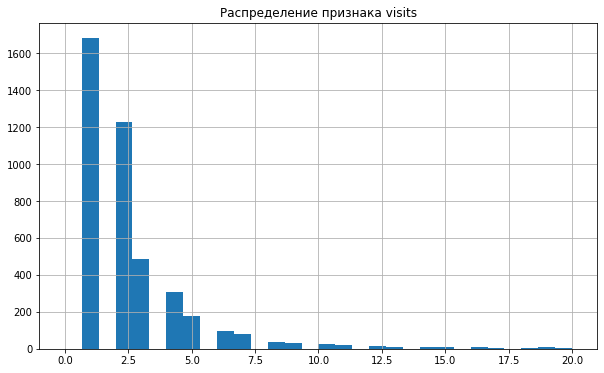

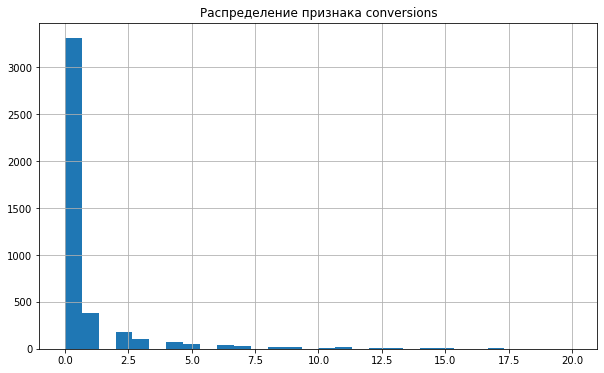

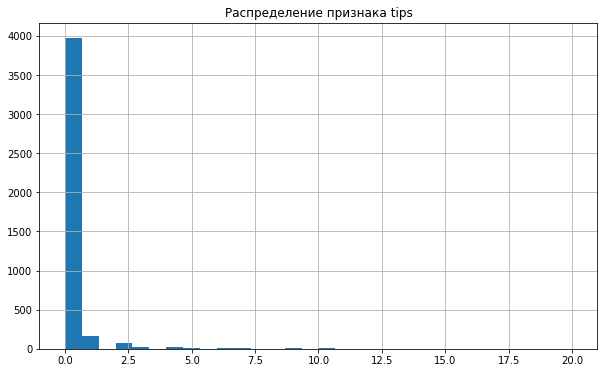

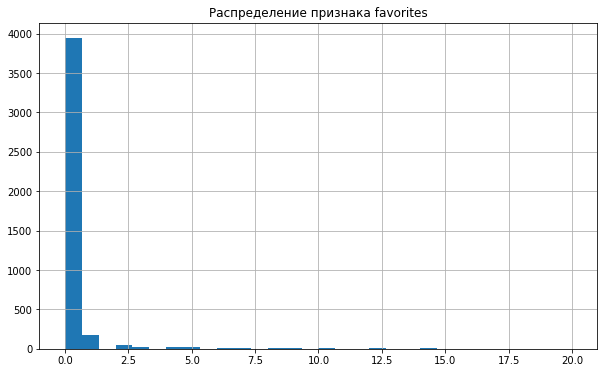

In [30]:
# посмотрим на распределение признаков и построим графики 
for i in {'visits', 'conversions', 'tips', 'favorites'}:
    print(i)
    print(np.percentile(features[i], [90, 95, 99])) # выведем перцентили
    str = 'Распределение признака '+ i
    plt.figure(figsize=(10,6))
    plt.title(str)
    plt.hist(features[i], bins=30, range=(0,20))
    plt.grid(True);

##### Выводы по графикам: 
- На каждого пользователя приходится от 1 до 5 сессий. Случаются и исключения, но они достаточно редки;
- К сожалению, но пользователи крайне редко добавляют объявления в избранное;
- Точно такая же ситуация и с просмотром рекомендованных объявлений;
- В основном, большая часть пользователей не совершает целевое действие - просмотр контактов - а тех, кто его совершает, крайне мало (менее пятисот человек);
- Полученные перцентили также подтверждают графики;
- В целом, можно было бы удалить выбросы, но как бы не получилось того, что удалив их - мы лишим себя наиболее активной части пользователей. 

[ 62.23       102.30666667 241.22533333]


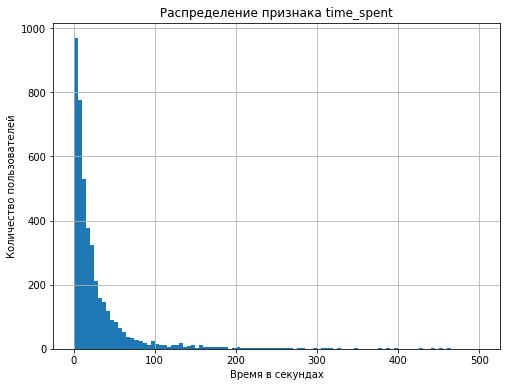

[14115.01666667 21850.21666667 33106.28      ]


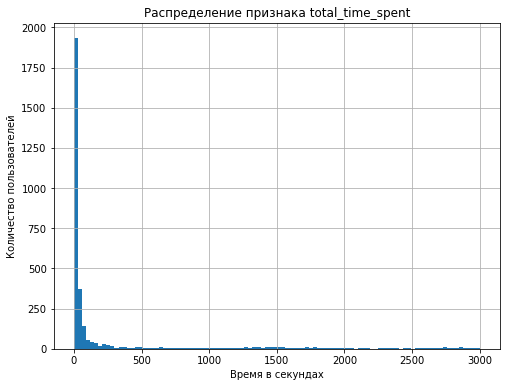

In [31]:
# построим графики распределения для показателей "продолжительность сеанса" и "общее время, проведенное каждом пользователем в приложении"
print(np.percentile(features['time_spent'], [90, 95, 99])) # перцентили
plt.figure(figsize=(8,6))
features['time_spent'].hist(bins=100, range=(0, 500))
plt.title('Распределение признака time_spent')
plt.xlabel('Время в секундах')
plt.ylabel('Количество пользователей')
plt.show()
print(np.percentile(features['total_time_spent'], [90, 95, 99])) # перцентили 
plt.figure(figsize=(8,6))
features['total_time_spent'].hist(bins=100, range=(0, 3000))
plt.title('Распределение признака total_time_spent')
plt.xlabel('Время в секундах')
plt.ylabel('Количество пользователей')
plt.show();

##### Выводы по графикам:
- Время каждого сеанса пользователя варьируется от 0 и плавно перемещается до 200 секунд. Существуют и те, у кого сеанса длятся больше, но их не так много;
- Общее время, проведенное каждым пользователем в приложении также варьируется от 0 и ниспадает до 500 секунд. Опять же, есть и те, у кого суммарное время пользования приложением больше, но их все также мало. 
- В обоих случаях мы видим, что крайне высок процент тех, кто практически сразу закрывает приложение, так и не успев им попользоваться. 

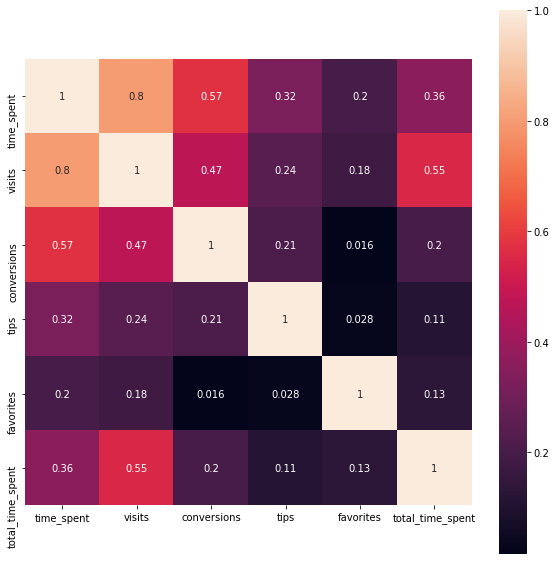

In [32]:
# матрица коллеряции для признаков
corr_m = features.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_m, square = True, annot = True,  ax=ax);

##### Выявленные корреляции:
- Сильная положительная корреляция между переменными time_spent и visits. Логично предположить, что пользователи, чаще использующие приложение, с каждым разом проводят в нем все больше времени;
- Средняя корреляция между переменными time_spent и conversions. Тот же самый эффект, чем больше длится сеанс пользователи, тем больше они вовлекаются в него и совершают покупки;
- Средняя корреляция между переменными visits и conversions. Вполне объяснимо, что чем чаще пользователи заходят в приложение, тем чаще они совершают целевое действие;
- Сильная положительная корреляция между общим временем, проведенным пользователями в приложении и количеством его визитов.
- В целом из таблицы корреляций мы видим сильную зависимость между количеством сессий и временем, проведенным пользователями в приложении. 

##### Разобьем, наконец, наших пользователей с помощью кластеризации, на основании получившихся признаков. 

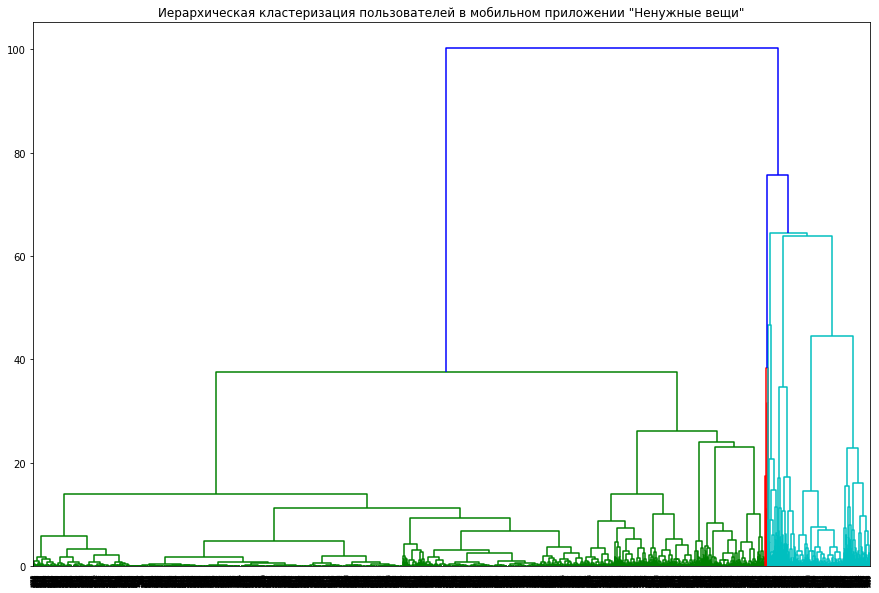

In [33]:
# построим дендограмму

# отбросим ненужный столбец с id пользователей и целевую переменную, чтобы модель не подглядывала
X = features.drop(['user_id', 'conversions'], axis=1)

# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация пользователей в мобильном приложении "Ненужные вещи"')
plt.show();

##### Оптимальное число кластеров для пользователей - 3.

In [34]:
# произведем кластеризацию

#обучим модель кластеризации на основании K-means
km = KMeans(n_clusters=3, random_state = 0) # три кластера
labels = km.fit_predict(X_sc) # применение алгоритма к кластерам и формирование векторов 

# поместим кластеры в наш датасет
features['cluster_km'] = labels
features.head()

,user_id,time_spent,visits,conversions,tips,favorites,total_time_spent,cluster_km
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,43.816667,5,0.0,0.0,0.0,21471.116667,1
1,00157779-810c-4498-9e05-a1e9e3cedf93,177.700000,10,11.0,0.0,2.0,21337.600000,1
2,00463033-5717-4bf1-91b4-09183923b9df,21.250000,2,0.0,0.0,0.0,24.716667,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,87.533333,7,0.0,0.0,0.0,18688.166667,1
4,00551e79-152e-4441-9cf7-565d7eb04090,9.333333,3,3.0,0.0,0.0,4892.516667,0


In [35]:
# посчитаем количество  пользователей  в каждом кластере
clusters_users = features.groupby('cluster_km', as_index=False).count()[['cluster_km', 'user_id']].rename(columns={'user_id': 'clusters_value'})

# процентное соотношение количества пользователей каждого кластера к общему
clusters_users['pies'] = (clusters_users['clusters_value'] / 4293) * 100
clusters_users

,cluster_km,clusters_value,pies
0,0,3649,84.998835
1,1,603,14.046122
2,2,41,0.955043


In [36]:
# статистика средних значений признаков для кластеров
clusters_mean = features.groupby('cluster_km').mean()

# добавим столбец pies в датасет
clusters_mean ['pies'] = clusters_users['pies']
clusters_mean

,time_spent,visits,conversions,tips,favorites,total_time_spent,pies
cluster_km,,,,,,,
0,19.120800,1.949849,0.682653,0.102220,0.175116,1139.075815,84.998835
1,61.966473,6.850746,1.902156,0.475954,0.815920,18637.348286,14.046122
2,407.490244,28.878049,21.731707,3.756098,6.975610,21809.404472,0.955043


- С помощью кластеризации мы разбили наших пользователей на три кластера, однако они получились достаточно неравными между собой;
- Самым большим получился кластер 1 - в него попало 85% всех пользователей, однако по остальным показателям он существенно проседает. Среднее время сеанса пользователей составило 19 минут, а суммарное время проведенное в приложении 19 часов. Практически не просматривают рекомендованные объявления и не добавляют объявления в избранное. Конверсия совершенно никакая (0,68%). Да и посещаемость у этого кластера низкая, в среднем 2 посещения на каждого пользователя;
- Средним получился кластер 2 - в него попало 14% от всех пользователей. По показателям он лучше предыдущего кластера, но есть куда расти. Среднее время сеанса пользователей составило 62 минуты, а суммарное время, проведенное в приложении 310 часов. Просматривают и добавляют объявления в избранное куда охотнее, да и конверсия в несколько раз лучше. К тому же посещаемость у них в среднем 7 визитов на каждого пользователя;
- Самым немногочисленным, но эффективным получился кластер 3. Всего 1% от общего количества пользователей, но этот 1% стоит оставшихся 99%. Среднее время сеанса пользователей составило почти 7 часов, а суммарное время использования приложения больше двух недель. Самый высокий показатель конверсии в целевое действие - просмотр контактов и уверенные показатели просмотра рекомендованных объявлений и добавления объявлений в избранное. Определенно, самые активные пользователи собрались в этом кластере. 

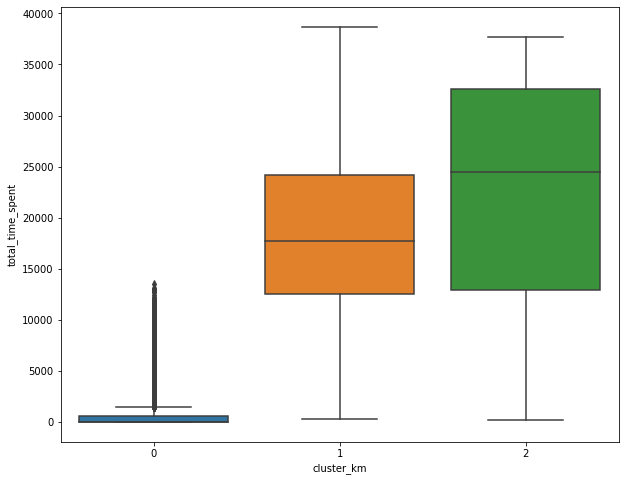

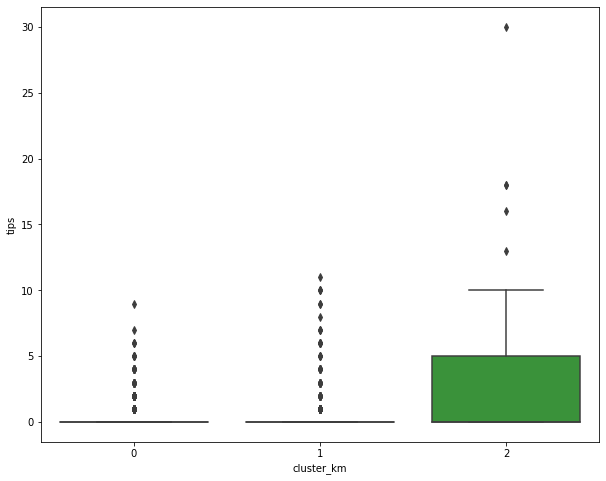

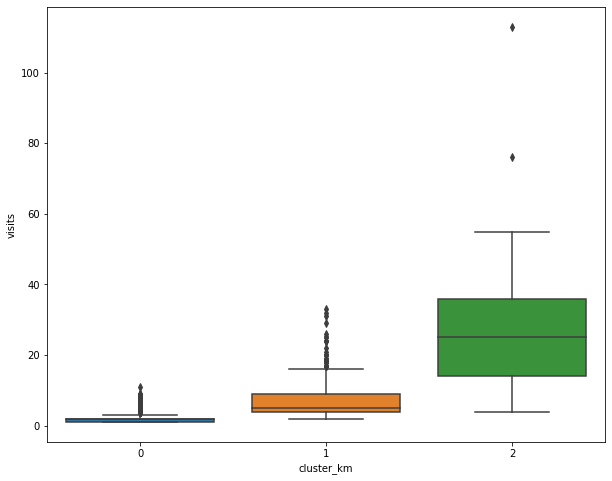

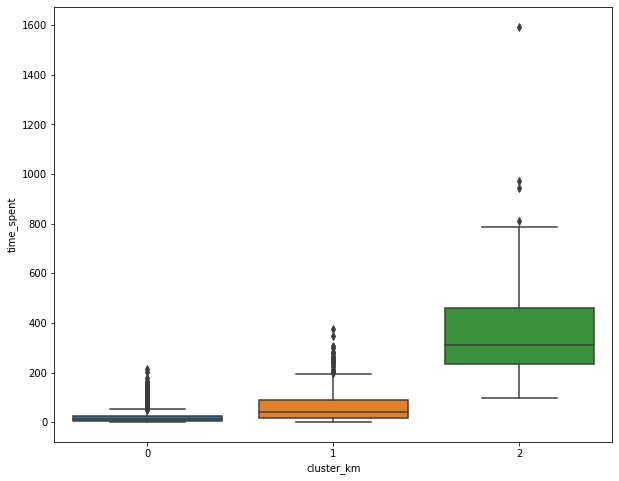

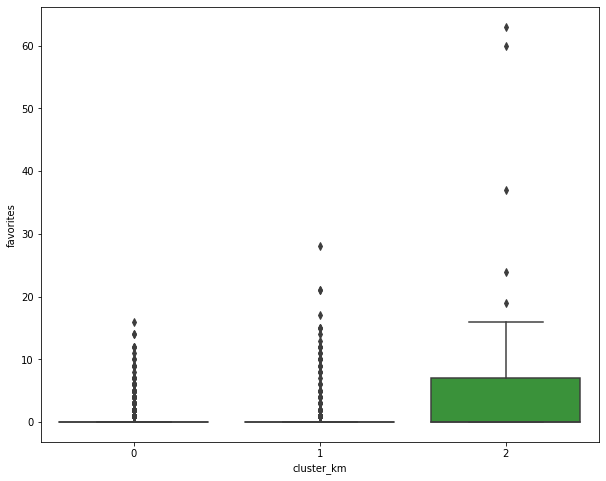

In [37]:
# построим графики распределения признаков для кластеров
for column in {'visits', 'total_time_spent', 'time_spent', 'tips', 'favorites'}:
    rcParams['figure.figsize'] = 10, 8
    sns.boxplot(x='cluster_km', y=column,  data=features)
    plt.show()

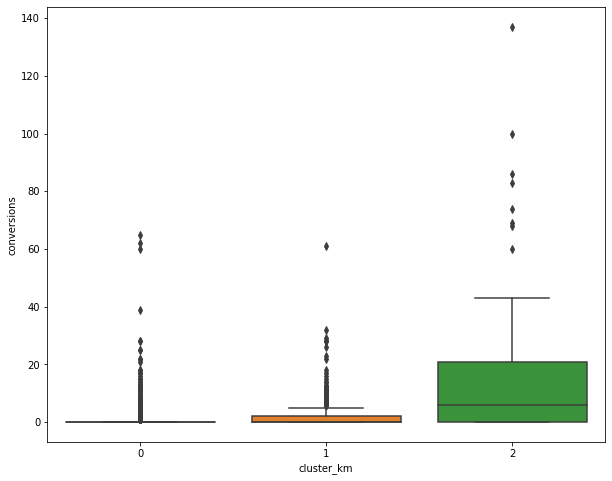

cluster_km
0     0.682653
1     1.902156
2    21.731707
Name: conversions, dtype: float64


In [38]:
# построим график распределения целевой переменной для кластеров
rcParams['figure.figsize'] = 10, 8
sns.boxplot(x='cluster_km', y='conversions',  data=features)
plt.show();
# выведем значения
print(clusters_mean['conversions'])

##### В прицнипе, построенные графики распределения признаков для кластеров подтверждают выводы, сделанные ранее.

### Шаг 5. Статистический анализ данных

In [39]:
# сформируем таблицу с общим количеством пользователей по источникам
total_users = sources.groupby('source', as_index=False).count().rename(columns={'user_id':'total_users'})
total_users

,source,total_users
0,google,1129
1,other,1230
2,yandex,1934


In [40]:
# сформируем таблицу с пользователями, совершившими целевое действие - просмотр контактов
goal_users = data.query('event_name=="show_contacts"').groupby(['source'], as_index=False).agg({'user_id':'nunique'}).rename(columns={'user_id':'goal_users'})

# объединим датасеты
conversion_users = pd.merge(goal_users, total_users, on='source')

# рассчитаем CR
conversion_users['cr'] = conversion_users['goal_users'] / conversion_users['total_users']
conversion_users

,source,goal_users,total_users,cr
0,google,275,1129,0.243578
1,other,228,1230,0.185366
2,yandex,478,1934,0.247156


In [41]:
# сформируем таблицу с пользователями, добавившими объявление в избранное
fav_users = data.query('event_name=="favorites_add"').groupby(['source'], as_index=False).agg({'user_id':'nunique'}).rename(columns={'user_id':'favorites_users'})

# объединим датасеты
fav_users_1 = pd.merge(fav_users, total_users, on='source')
# рассчитаем CR
fav_users_1['cr'] = fav_users_1['favorites_users'] / fav_users_1['total_users']
fav_users_1

,source,favorites_users,total_users,cr
0,google,114,1129,0.100974
1,other,77,1230,0.062602
2,yandex,160,1934,0.082730


In [42]:
# произведем проверку первой пары статистических гипотез

# H0 - Конверсия в просмотр контактов между пользователяи, установшими приложение по ссылке из yandex и пользователями, установшими приложение по ссылке из google, одинаковая
# H1 - Конверсия в просмотр контактов между пользователями, установившими приложение по ссылке из yandex и пользователями, установившими приложение по ссылке из google, различается

alpha = .05 # критический уровень статистической значимости

purchases = np.array([275, 478])
leads = np.array([1129, 1934])

p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
distr = stats.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('z_value =', z_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

z_value = -0.2218487822311678
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [43]:
# произведем проверку второй пары статистических гипотезы

# H0 - Конверсия в добавление объявления в избранное между пользователями, установившими приложение по ссылке из других источников не отличается от конверсии пользователей, установивших приложение по ссылке из yandex или google
# H1 - Конверсия в добавление объявления в избранное между пользователями, установшими приложение по ссылке из других источников отличается от конверсии пользователей, установивших приложение со ссылке из yandex или google

alpha = .05 # критический уровень статистической значимости

purchases = np.array([114, 160])
leads = np.array([1129, 1934])

p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
distr = stats.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('z_value =', z_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

z_value = 1.7067679449703979
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Вывод
- На основании проведенного статистического анализа данных можно сделать вывод о том, что разницы между конверсией в просмотр контактов между пользователями, пришедшими из yandex, и пользователями, пришедшими из google, нет;
- Также разницы в конверсии в добавлении объявлений в избранное между пользователями, пришедшими из yandex и пользователями, пришедшими из google, нет;
- Можно считать, что по итогу статистического анализа данных были подтверждены обе нулевые гипотезы, выдвинутые в процессе исследования. 

### Шаг 6. Общий вывод и рекомендации

##### Общий вывод
- всего приложением воспользовались 4293 пользователей;
- большего всего трафика приходит через Яндекс, а меньше всего через Googlе - 1934 против 1129;
- больше всего активности пользователей происходит в будни, а меньше в выходные;
- конверсия в просмотр контактов для всех пользователей составляет 23%.

##### Оптимальное количество кластеров - 3.

###### Кластер 1 
- 85% от общего количества пользователей. Среднее время сеанса 19 минут, суммарное время в приложении 19 часов. Практически отсувствуют показатели вовлеченности и низкая конверсия в целевое действие;

##### Кластер 2
- 14% от общего количества пользователей. Среднее время сеанса 62 минуты, суммарное время в приложении 310 часов. Показатели вовлеченности значительно выше, чем у первого кластера;

##### Кластер 3
- 1% от общего количества пользователей. Среднее время сеанса 7 часов, суммарное время в приложении более двух недель. Самые высокие показатели вовлеченности и конвервии в целевое действие. Наиболее активные пользователи в этом кластере. 

##### В процессе работы были выдвинуты следующие пары гипотез:

##### Первая пара
- H0 - Конверсия в просмотр контактов между пользователяи, установшими приложение по ссылке из yandex и пользователями, установшими приложение по ссылке из google, одинаковая;
- H1 - Конверсия в просмотр контактов между пользователями, установившими приложение по ссылке из yandex и пользователями, установившими приложение по ссылке из google, различается.

##### Вторая пара
- H0 - Конверсия в добавление объявления в избранное между пользователями, установившими приложение по ссылке из yandex не отличается от конверсии пользователей, установивших приложение по ссылке из google;
- H1 - Конверсия в добавление объявления в избранное между пользователями, установшими приложение по ссылке из yandex отличается от конверсии пользователей, установивших приложение со ссылке из google.

##### По итогу статистического анализа можно сделать вывод о том, что между долями нет значимой разницы, а следовательно обе гипотезы H0 были подтверждены. Следовательно, разницы в конверсии в просмотр контактов между пользователи, пришедшими из yandex и пользователями, пришедшими из google, нет. Также разницы в конверсии в добавление контактов между пользователями из yandeх и пользователями из google, нет.

##### Рекомендации
- Развивать рекламу в Google и других источниках. Хорошо, конечно, что через Яндекс столько приходит пользователей, но нужно охватить как можно больше пользователей;
- Настроить более точно алгоритм подбора рекомендованных объявлений. Вполне вероятно, что пользователи не просматривают рекомендованные объявления и не добавляют объявления в избранное из-за того, что им система не предлагает им действительно нужные предложения;
- Стимулировать пользователей к покупкам. Допустим, запустить начсление баллов за покупку. 